In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, unix_timestamp, avg, expr
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:

# Start Spark Session
spark = SparkSession.builder.appName("PassengerBehaviorAnalysis").getOrCreate()

In [1]:
file_id = "1t3e3VNbOlw9v1n-ZxDEfEUAe7ENULKRu"  # Extract from share link
url = f"https://drive.google.com/uc?id={file_id}"

In [3]:
import gdown
import zipfile
import os

# Google Drive URL (Make sure it's a direct download link or file ID-based)
url = "https://drive.google.com/uc?id=1t3e3VNbOlw9v1n-ZxDEfEUAe7ENULKRu"

# Set correct relative paths
base_path = "/home/ariso/Documents/bigDataAssignment/NYC_Taxi_Trip_Data_Analysis"
zip_path = os.path.join(base_path, "data", "cleanedData.zip")
extract_to = os.path.join(base_path, "data", "cleanedData1")

# Ensure the data directory exists
os.makedirs(os.path.dirname(zip_path), exist_ok=True)

# Download the zip file
gdown.download(url, zip_path, quiet=False)

# Extract the contents to the desired folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Done: Extracted to", extract_to)


Downloading...
From (original): https://drive.google.com/uc?id=1t3e3VNbOlw9v1n-ZxDEfEUAe7ENULKRu
From (redirected): https://drive.google.com/uc?id=1t3e3VNbOlw9v1n-ZxDEfEUAe7ENULKRu&confirm=t&uuid=06563379-39db-4e51-a634-bfb175b68cc4
To: /home/ariso/Documents/bigDataAssignment/NYC_Taxi_Trip_Data_Analysis/data/cleanedData.zip


KeyboardInterrupt: 

In [10]:
# Load cleaned data
df_new = spark.read.parquet("/home/ariso/Documents/bigDataAssignment/NYC_Taxi_Trip_Data_Analysis/data/cleanedData")

In [11]:

# 1. Calculate trip duration in minutes
df_new = df_new.withColumn(
    "trip_duration_min",
    (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 60
)

# 2. Create ride_type column: 'Solo' if passenger_count == 1 else 'Group'
df_new = df_new.withColumn(
    "ride_type",
    when(col("passenger_count") == 1, "Solo").otherwise("Group")
)

# 3. Aggregate stats by ride_type (Solo vs Group)
agg_ride_type = df_new.groupBy("ride_type").agg(
    avg("fare_amount").alias("avg_fare"),
    avg("trip_distance").alias("avg_distance"),
    avg("trip_duration_min").alias("avg_duration_min"),
    avg("tip_amount").alias("avg_tip")
)

agg_ride_type.show()

# 4. Aggregate stats by passenger_count (detailed segmentation)
agg_passenger_count = df_new.groupBy("passenger_count").agg(
    avg("fare_amount").alias("avg_fare"),
    avg("trip_distance").alias("avg_distance"),
    avg("trip_duration_min").alias("avg_duration_min"),
    avg("tip_amount").alias("avg_tip")
).orderBy("passenger_count")

agg_passenger_count.show()

# 5. Calculate average tip ratio (tip_amount / fare_amount) by passenger_count for visualization
df_tip_ratio = df_new.withColumn("tip_ratio", expr("tip_amount / fare_amount")) \
    .groupBy("passenger_count") \
    .agg(avg("tip_ratio").alias("avg_tip_ratio")) \
    .orderBy("passenger_count")

+---------+------------------+------------------+-----------------+------------------+
|ride_type|          avg_fare|      avg_distance| avg_duration_min|           avg_tip|
+---------+------------------+------------------+-----------------+------------------+
|    Group|23.526486298845317| 4.325399361876358|20.32200483821459|4.0891243972762545|
|     Solo| 20.18988423422253|3.5556389382523537|18.33242583966856| 3.755296596937398|
+---------+------------------+------------------+-----------------+------------------+



+---------------+------------------+------------------+------------------+------------------+
|passenger_count|          avg_fare|      avg_distance|  avg_duration_min|           avg_tip|
+---------------+------------------+------------------+------------------+------------------+
|              1| 20.18988423422253|3.5556389382523537| 18.33242583966856| 3.755296596937398|
|              2| 23.39797545007845| 4.344290902926339|20.237660925396998| 4.170095863763038|
|              3| 23.17363400564298| 4.153660353621334|20.110746281765156| 3.911004006288483|
|              4|24.972340881229666| 4.473998421846196| 21.23811887349869|3.8248718031816296|
+---------------+------------------+------------------+------------------+------------------+



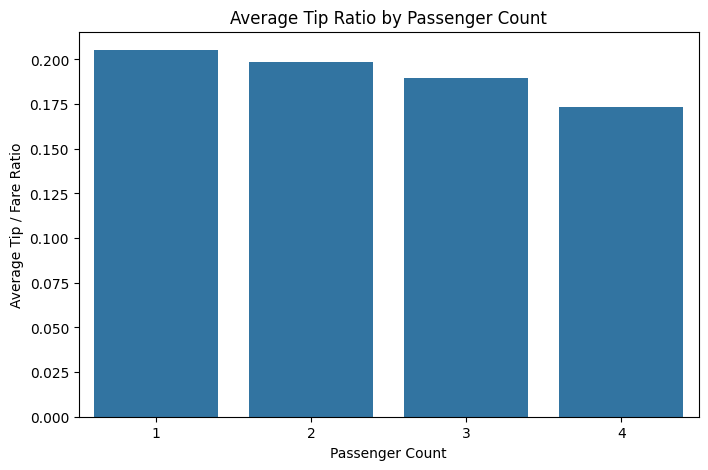

In [12]:
# 6. Collect aggregated tip ratio to Pandas for plotting
pdf_tip_ratio = df_tip_ratio.toPandas()

# 7. Plot average tip ratio by passenger_count using Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(x="passenger_count", y="avg_tip_ratio", data=pdf_tip_ratio)
plt.title("Average Tip Ratio by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Average Tip / Fare Ratio")
plt.show()